In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import csv
import sys
#from sklearn.metrics import mean_squared_error
import math
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.engine.topology import Layer
from matplotlib.pyplot import axis
import formatDataSet
import transformations
import pandas as pd

Using TensorFlow backend.


Running Main FormatDataSet.py ... 

======> Purpose is to Generate Per Subject Models ... 

Reading the Subject Pickle File ... 
  .\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle
.\Datasets\2016-5-5-13-7\DataSet_All.pickle
.\Datasets\2016-5-5-13-7\trialType_All.pickle


C:\Users\kb4000\Documents\Python\modellingbyrnn\transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


357
494
499
500
499
500
500
500
500
500


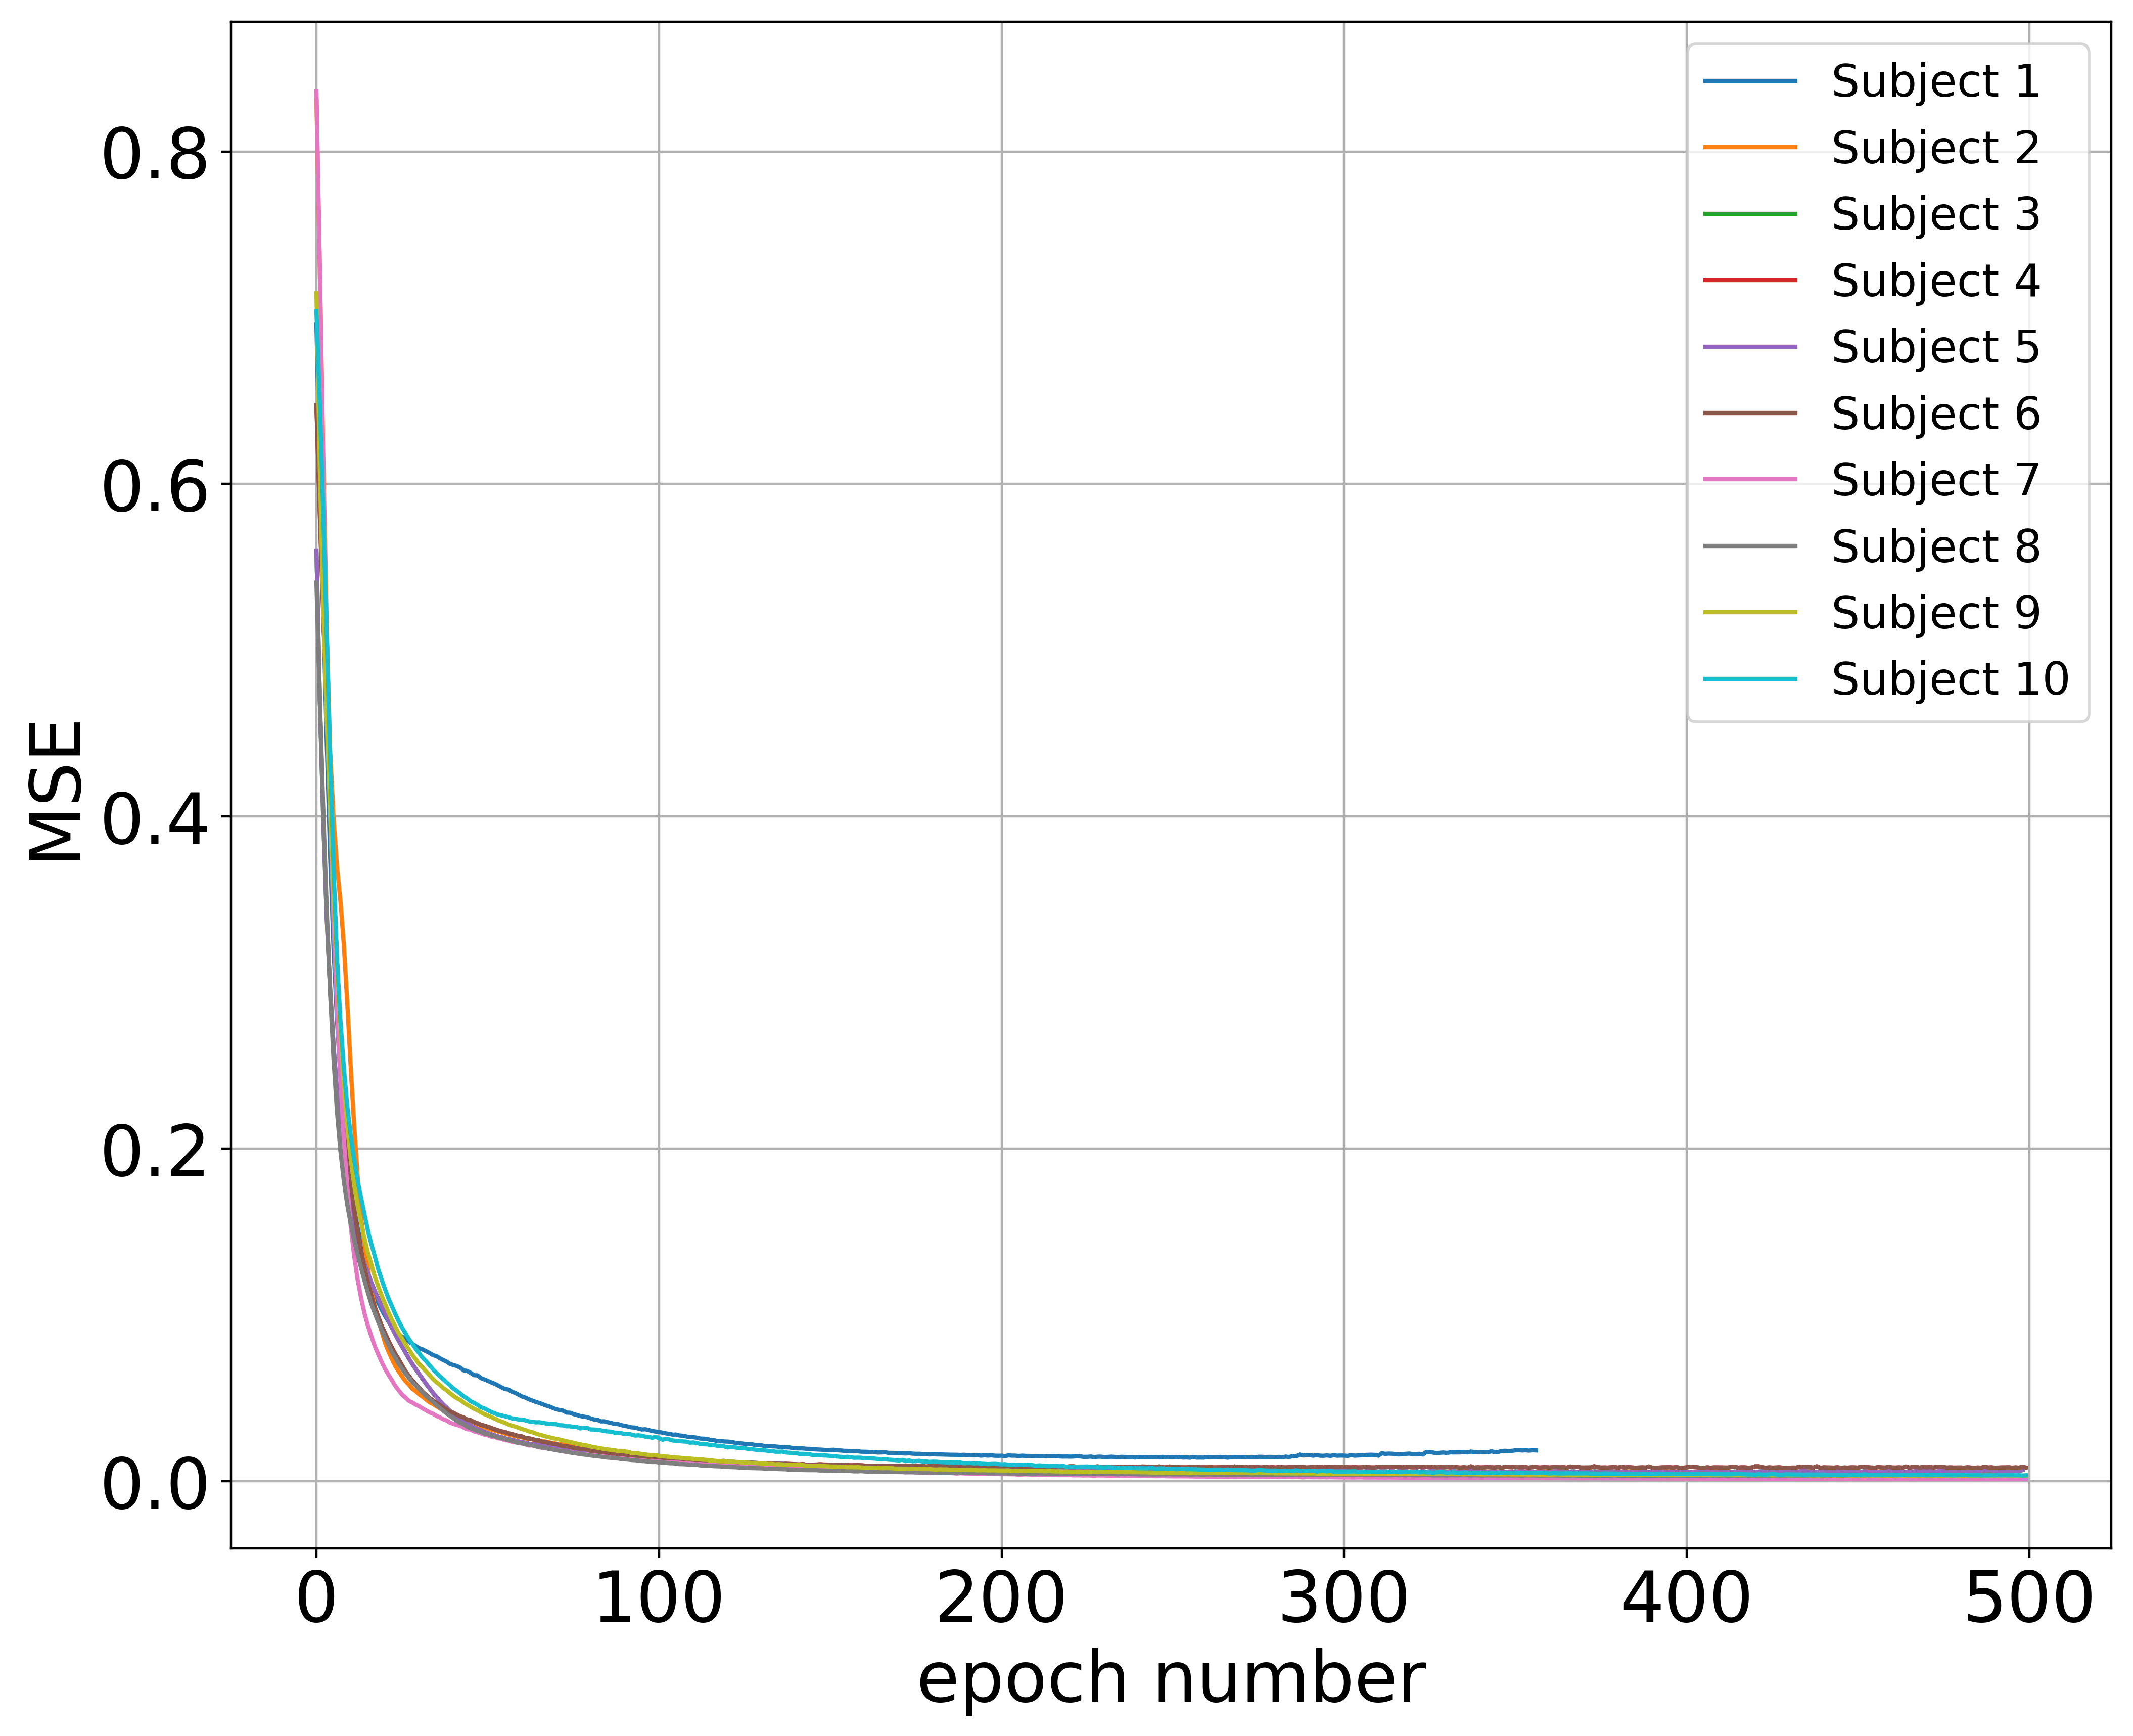

In [23]:
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
fileTimeList = ['2016-4-19-14-4', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']

#fileTimeList = ['2016-4-19-14-4']
timeStepList = [0]#, 10, 20, 30]
learningRate = [0.0002]#, 0.0002, 0.0001, 0.0001]
markerList = ['-b','-c', '-g', '-r']
i = 0
integrationLength = 45
plt.figure(figsize=(12, 10), dpi=400)

j = 0
for subjectID in fileTimeList:
    for i in range(len(timeStepList)):
        subjectID = '\\' + subjectID + '\\'
        file_name = r'.\Results\Weights\PerSubjectModel'+subjectID+'ValidationLoss_'+str(integrationLength)+'_'+ str(timeStepList[i]) +'_' +str(learningRate[i]) +'_500.pickle'
        valLoss = pd.read_pickle(file_name)
        print(len(valLoss))
        plt.plot(np.arange(len(valLoss)), valLoss, label = 'Subject ' + str(j+1))
    j = j + 1

plt.grid(True)
plt.legend(loc = 'upper right', fontsize = 16)
#plt.title("Gaze Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('epoch number', fontsize = 25)
plt.ylabel('MSE', fontsize = 25)
#plt.ylim(-0.05,10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig('allSubjectsValLoss.png', dpi=600)
plt.show()


In [5]:
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']

fileTimeList = ['2016-4-19-14-4', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']

timeStepList = [0]#, 10, 20, 30]
learningRate = [0.0002]#, 0.0002, 0.0001, 0.0001]
integrationLength = 45
#PredictionLength = 35
#PredictionLength = 15
blankPeriodDuration = 38
featureDimension = 17

trainDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))
testDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))

print(trainDataSetAllSubject.shape)
trainTrialInfoAll = np.chararray(1,itemsize = 14)
testTrialInfoAll = np.chararray(1,itemsize = 14)
trainTrialInfoAll[0] = 'tr_0_type_t0'
testTrialInfoAll[0] = 'tr_0_type_t0'

for subjectID in fileTimeList:
    (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo) = createTrainTestDataSets(subjectID)
    trainDataSet, testDataSet = correctForNegativeAngles(trainDataSet, testDataSet)
    trainDataSetAllSubject = np.vstack((trainDataSetAllSubject, trainDataSet))
    testDataSetAllSubject = np.vstack((testDataSetAllSubject, testDataSet))
    print(trainTrialInfo.shape)
    print(trainTrialInfoAll.shape)
    trainTrialInfoAll = np.hstack((trainTrialInfoAll, trainTrialInfo))
    testTrialInfoAll = np.hstack((testTrialInfoAll, testTrialInfo))
trainDataSetAllSubject = np.delete(trainDataSetAllSubject, 0,0)
testDataSetAllSubject = np.delete(testDataSetAllSubject, 0,0)
trainTrialInfoAll = np.delete(trainTrialInfoAll, 0)
testTrialInfoAll = np.delete(testTrialInfoAll, 0)

print('train Data Set Shape = ', trainDataSetAllSubject.shape)
print('test Data Set Shape = ', testDataSetAllSubject.shape)
print('train info Shape = ', trainTrialInfoAll.shape)
print('test info Shape = ', testTrialInfoAll.shape)
ntrainDataSetAllSubject = normalizeDataSet(trainDataSetAllSubject)
ntestDataSetAllSubject = normalizeDataSet(testDataSetAllSubject)


integrationList = [2]
for integrationLength in integrationList:
    allModelOutputs = np.zeros((len(timeStepList),testDataSetAllSubject.shape[0],8))
    allTestOutputs = np.zeros((len(timeStepList), testDataSetAllSubject.shape[0],8))
    i = 0
    for timeStep in timeStepList:
        weights_path = r'.\Results\Weights\Integration_2_Models\weights_' + str(integrationLength) + '_'+str(timeStep)+'_'+str(learningRate[i])+'_2000'
        print(weights_path)
        model = createRNN(integrationLength, weights_path, learningRate[i])
        modelOutput, testingOutput = testModel(ntestDataSetAllSubject, model, integrationLength=integrationLength, timeStep=timeStep)
        allModelOutputs[i,:,:] = modelOutput
        allTestOutputs[i,:,:] = testingOutput
        i = i + 1
    TestingResult = UnnormalizeDataSet(testDataSetAllSubject, allTestOutputs)
    ModelResult = UnnormalizeDataSet(testDataSetAllSubject, allModelOutputs)
    #pd.to_pickle(ModelResult,  r'.\Results\ModelOutput\17_Feat_8_Output_LSTM_25\modelOutput_' + 
    #             str(integrationLength) + '.pickle')
    
    #pd.to_pickle(TestingResult,  r'.\Results\ModelOutput\17_Feat_8_Output_LSTM_25\testingInput_' + 
    #             str(integrationLength) + '.pickle')        




        
 

(1, 83, 17)


NameError: name 'createTrainTestDataSets' is not defined

In [11]:
fileTimeList = ['2016-4-19-14-4', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56', 
                '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
integrationLength = 45
timeStep = 13
i = 0
subjectID = '2016-4-19-14-4'
subjectID = '\\' + subjectID + '\\'
pickleFileName = r'.\Results\Figures\Ablation Study\PerSubjectModel'+subjectID+'mean_'+str(integrationLength)+'_'+str(timeStep)+'.pickle'
myTest = pd.read_pickle(pickleFileName)
np.set_printoptions(suppress=True)
print(myTest[:,0,:])

[[  1.56921019   2.23208194  16.88723453   4.00556619   0.05277854
    5.46022234   0.20252242   9.18819854]
 [  0.33177357   0.94201948  17.80678583   3.81346264   0.05257638
    6.7782471    1.8437575   10.52775123]
 [  1.32484682   2.30742852   0.50046526   3.66295666   0.05988119
    1.27366829   1.09075643   6.82694963]
 [  1.15813072   1.91585486   0.25764487   2.53439157   0.05858675
    1.59206673   1.17050477   7.39734134]
 [  1.11696045   0.73410348   1.23098391   0.68616134   0.04385382
    1.26633629   0.98012072  15.85057865]
 [  0.75960755   0.11848186   2.41068205   1.26005437   0.03287171
    2.2748947    0.38981594  19.72943432]
 [  1.09543234   0.51419522   1.44814785   1.56466349   0.02834498
    2.29717355   1.84381145  16.9871216 ]
 [  1.16966261   0.46255701   1.23088272   2.4063616    0.0283621
    2.31441389   2.0585649   12.45968571]
 [  1.12758075   0.30452891   0.81481756   2.43539038   0.02808291
    3.04532343   1.12985064  10.52800385]
 [  1.0571067    0.8